In [1]:
!pip3 install requests_cache
!pip3 install torch
!pip3 install transformers
!pip3 install SentencePiece 

In [2]:
# import standard libraries
import random
import os
import io
import zipfile
import requests as rq
import requests_cache as rqc
import numpy as np
import pandas as pd
import torch as pt
import transformers as tsf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from tqdm.notebook import tqdm

In [3]:
# print environment information
print("ENVIRONMENT INFORMATION")
print("Using numpy version %s" % np.__version__)
print("Using pandas version %s" % pd.__version__)
print("Using pytorch version %s" % pt.__version__)
print("Using transformers version %s" % tsf.__version__)

ENVIRONMENT INFORMATION
Using numpy version 1.23.5
Using pandas version 1.5.3
Using pytorch version 1.12.1
Using transformers version 4.24.0


In [4]:
# determine available device
device = pt.device("cpu")
if pt.cuda.is_available() :
  device = pt.device("cuda")
  print("Using GPU acceleration")
  ! nvidia-smi
else:
  print("NOT using GPU acceleration")

Using GPU acceleration
Sat Apr 22 15:26:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8     5W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [5]:
# global configuration
MAXIMUM_PARAPHRASED_SAMPLES_TO_RETURN = 3
TOKENIZATION_MAX_LENGTH = 1024
SUMMARIZATION_MAX_LENGTH = 32
#LLM_MODEL_PARAPHRASER = "eugenesiow/bart-paraphrase"
LLM_MODEL_PARAPHRASER = "tuner007/pegasus_paraphrase"
LLM_MODEL_CORRECTOR = "KES/T5-KES"

In [6]:
# global initialization - reproducibility
random.seed(0)
np.random.seed(0)
pt.manual_seed(0)

# initialize tqdm for pandas usage
tqdm.pandas()

# disable unimportant warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [7]:
""" Reads the data from a remote zip file """
def get_data_from_remote_zip_file(file_url, file_name):

  response = rqc.CachedSession().get(file_url)
  binary_data = io.BytesIO(response.content)

  raw_data = None

  with zipfile.ZipFile(binary_data) as z:
    with z.open(file_name) as f:
      raw_data = pd.read_csv(f)
      
  return raw_data

In [11]:
# URL and FILE NAME for fake news data
PROCESSED_FAKE_NEWS_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Content-Enhancement/raw/main/data/processed/fake_news_data_preprocessed.zip"
PROCESSED_FAKE_NEWS_FILE_NAME = "fake_news_data_preprocessed.csv"

# obtain the fake news dataframe
fake_news_data_frame = get_data_from_remote_zip_file(PROCESSED_FAKE_NEWS_URL, PROCESSED_FAKE_NEWS_FILE_NAME)

In [12]:
# create the tokenizer and model used for paraphrasing
paraphrasing_tokenizer = PegasusTokenizer.from_pretrained(LLM_MODEL_PARAPHRASER, use_fast = True)
paraphrasing_model = PegasusForConditionalGeneration.from_pretrained(LLM_MODEL_PARAPHRASER).to(device)

In [13]:
"""Retrieve the length of a text tokenization sequence"""
def get_tokenization_length(tokenizer, text) :
  tokens = tokenizer(text, max_length = 1024, truncation = True)
  
  return len(tokens["input_ids"])

standard_tokenization_length = lambda text : get_tokenization_length(
    paraphrasing_tokenizer,
    text
)

In [14]:
# get the distribution for the tokenization length 
tokenization_length_distribution = fake_news_data_frame["title"].apply(standard_tokenization_length)

In [15]:
print("Number of title tokens basic statistics: ")
print(tokenization_length_distribution.describe())

Number of title tokens basic statistics: 
count    1056.000000
mean       15.263258
std         7.372346
min         2.000000
25%        10.000000
50%        14.000000
75%        19.000000
max        61.000000
Name: title, dtype: float64


In [16]:
print("Number of title tokens series deciles: ")
tokenization_length_distribution.quantile(np.arange(0, 1, 0.1))

Number of title tokens series deciles: 


0.0     2.0
0.1     7.0
0.2     9.0
0.3    11.0
0.4    13.0
0.5    14.0
0.6    16.0
0.7    17.0
0.8    21.0
0.9    25.0
Name: title, dtype: float64

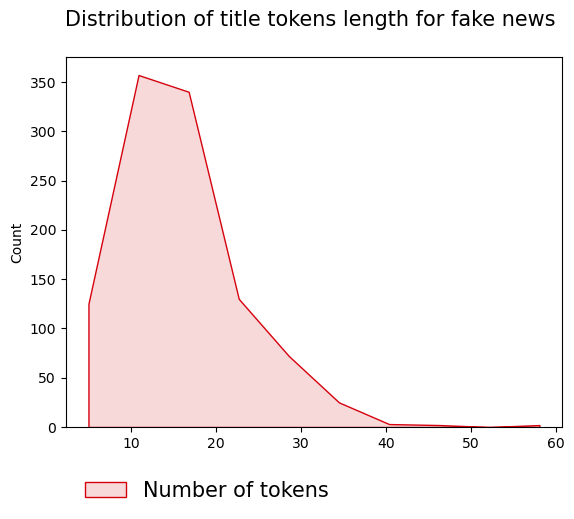

In [17]:
# plot the distribution length
plt.rcParams["patch.force_edgecolor"] = False

plt.rcParams['patch.edgecolor'] = 'none'

sns.histplot(
    tokenization_length_distribution.values, 
    color = "#D6000D", 
    alpha = 0.15, 
    element = "poly", 
    bins = 10
  )

plt.legend(
    ["Number of tokens"],
    loc = 'lower left',
    bbox_to_anchor = (0, -0.25),
    ncol = 1,
    framealpha = 0,
    fontsize = 15
  )

plt.title("Distribution of title tokens length for fake news \n", fontsize = 15)

plt.show()

In [18]:
""" Creates a paraphrased title """
def get_paraphrased_title_samples (
    summarization_tokenizer,
    summarization_model,
    title,
    samples_returned = MAXIMUM_PARAPHRASED_SAMPLES_TO_RETURN,
    tokenization_maximum_length = SUMMARIZATION_MAX_LENGTH,
    summarization_maximum_length = SUMMARIZATION_MAX_LENGTH,
    device = pt.device("cpu"),
    include_original = True,
    **kwargs
  ) :

  title_tokens = summarization_tokenizer(
      title, 
      return_tensors ='pt',
      truncation = True, 
      max_length = tokenization_maximum_length
    )

  # summarize at approximately the same length as initial content
  summarization_length = min(int(len(title_tokens['input_ids'][0]) * 1.25), SUMMARIZATION_MAX_LENGTH)

  generated_ids = summarization_model.generate(
        title_tokens['input_ids'].to(device),
        max_length = summarization_length,
        do_sample = True,
        num_return_sequences = samples_returned,
        **kwargs    
    )
  
  generated_samples = summarization_tokenizer.batch_decode(
      generated_ids, 
      skip_special_tokens=True
    )

  if (include_original) :
    generated_samples = np.concatenate(([title], generated_samples))

  return np.unique(generated_samples)

In [19]:
# create convenience paraphrasing function
get_standard_paraphrased_title_samples = lambda title : get_paraphrased_title_samples (
    paraphrasing_tokenizer,
    paraphrasing_model,
    title,
    device = device,
    top_k= 1000, #consider a large variety of candidates
    top_p = 0.95, #consider a high probability limit for selecting the next token
    temperature = 1.15, #allow a higher degree of variety 
    repetition_penalty = 100000.0, #force diverse results
    early_stopping = True
)

In [20]:
""" Creates paraphrased titles from fake news dataframe"""
def get_standard_paraphrased_title_samples_from_dataframe(item) :
  paraphrased_content_data = get_standard_paraphrased_title_samples (
      item["title"]
    )
  
  paraphrased_content_original_index = np.repeat(item["original_index"], paraphrased_content_data.shape[0])

  paraphrased_content_dataframe = pd.DataFrame({
      "original_index": paraphrased_content_original_index,
      "paraphprased_title": paraphrased_content_data
  })

  return paraphrased_content_dataframe

# get paraphrased content from dataframe
paraphrased_content = fake_news_data_frame.progress_apply(get_standard_paraphrased_title_samples_from_dataframe, axis = 1)
paraphrased_samples_dataframe = pd.concat(paraphrased_content.values, ignore_index = True)

  0%|          | 0/1056 [00:00<?, ?it/s]

In [21]:
""" Creates a corrected version of the pharaphrased title """
def get_corrected_title_sample (
    correction_tokenizer,
    correction_model,
    title,
    tokenization_maximum_length = SUMMARIZATION_MAX_LENGTH,
    summarization_maximum_length = 2 * SUMMARIZATION_MAX_LENGTH,
    device = pt.device("cpu"),
    **kwargs
  ) :

  title_tokens = correction_tokenizer(
      title, 
      return_tensors='pt',
      truncation=True, 
      max_length = tokenization_maximum_length
    )

  generated_ids = correction_model.generate(
        title_tokens['input_ids'].to(device),
        max_length = summarization_maximum_length,
        do_sample = True,
        **kwargs    
    )
  
  generated_samples = correction_tokenizer.batch_decode(
      generated_ids, 
      skip_special_tokens=True
    )

  corrected_sentences = "".join(generated_samples)
  return corrected_sentences

In [22]:
# create the tokenizer and model used for correction
correction_tokenizer = tsf.AutoTokenizer.from_pretrained(LLM_MODEL_CORRECTOR, use_fast = True)
correction_model = tsf.AutoModelForSeq2SeqLM.from_pretrained(LLM_MODEL_CORRECTOR).to(device)

In [23]:
# create convenience correction function
get_standard_corrected_title_sample = lambda title : get_corrected_title_sample (
    correction_tokenizer,
    correction_model,
    title,
    device = device,
    top_k= 1000, #consider a large variety of candidates
    top_p = 0.95, #consider a high probability limit for selecting the next token
    temperature = 0.95, #allow a lower degree of variety 
    early_stopping = True
)

In [24]:
""" Creates corrected titles from paraphrased inputs"""
def get_standard_corrected_title_samples_from_dataframe(item) :
  corrected_content_data = get_standard_corrected_title_sample (
      item["paraphprased_title"]
    )
  
  return corrected_content_data

# get paraphrased content from dataframe
corrected_content = paraphrased_samples_dataframe.progress_apply(get_standard_corrected_title_samples_from_dataframe, axis = 1)

  0%|          | 0/3294 [00:00<?, ?it/s]

In [ ]:
# create the dataframe for corrected content
corrected_content_dataframe = pd.DataFrame({
    "original_index": paraphrased_samples_dataframe["original_index"].values,
    "title": corrected_content
})

In [ ]:
# save the processed data
corrected_content_dataframe.to_csv(
    "./data/processed/generated_titles.zip",
    compression = {
        "method" : "zip", 
        "archive_name" : "generated_titles.csv"
    }
  )